In [1]:
from dotenv import load_dotenv

load_dotenv("app/.env")

True

In [2]:
import sys
import os
os.environ['MLFLOW_TRACKING_URI'] = 'http://192.168.3.3:5000'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://192.168.3.3:9000'
os.environ['ARTIFACT_ROOT'] = 's3://mlflow/'
os.environ['AWS_ACCESS_KEY_ID'] = 'strong_mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'strong_mlflow'

sys.path.append("./app")

In [3]:
import json
import time

import mlflow
import mlflow.data
import mlflow.data.pandas_dataset

import pandas as pd

from mlflow.metrics import make_metric, MetricValue
from mlflow.metrics.base import MetricValue, standard_aggregations
from mistralai import Mistral
from tqdm.auto import tqdm

from core.chain import retriever, get_rag_chain

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Тестирование качества ретривера

Для набора эталонных вопросов были определены "таргет" чанки, которые ретривер должен добавить в контекст для правильного ответа на вопрос.  
Методика - получить текущий набор из top-k чанков и посмотреть, на какой позиции находится целевой чанк.

In [14]:
df = pd.read_json("data/target_dataset.json")
df

,question,target_chunk,chunks_example,target_answer,answer_example
0,Для чего нужен метод Гаусса?,[Gauss method (Метод Гаусса).md],"[Gauss method (Метод Гаусса).md, Gauss method ...",Метод Гаусса — это алгоритм для решения систем...,Метод Гаусса — это алгоритм для решения систем...
1,Что такое гиперплоскости?,[Hyperplanes(Гиперплоскости).md],"[Hyperplanes(Гиперплоскости).md, Hyperplanes(Г...",Гиперплоскости — это обобщение плоскостей в пр...,Гиперплоскости — это обобщение плоскостей в пр...
2,Для чего используется метод Low Rank Adaptation?,[Low Rank Adaptation (LoRA).md],"[Low Rank Adaptation (LoRA).md, DoRA - Weight...",Low Rank Adaptation (LoRA) is a method used fo...,Low Rank Adaptation (LoRA) is a method used fo...
3,"Какое определение дается системе, состояния эл...",[Markov chains.md],"[Markov chains.md, Attention (DL).md, Rule Bas...","Система, в которой состояния элемента определя...","Система, в которой состояния элемента определя..."
4,Какое вино градусов 17-18?,[Muscat (Мускат).md],"[Muscat (Мускат).md, Wine metacard (Вино меток...","На основе предоставленной информации, можно сд...","Вино с градусов 17-18, которое упоминается в к..."
...,...,...,...,...,...
95,Какие преимущества дает передача функции в тес...,[Фикстуры.md],"[Фикстуры.md, Параметризация тестов.md, Параме...",Передача функции в тест как параметр в Pytest ...,Передача функции в тест как параметр в Pytest ...
96,Какую кастрюлю лучше всего использовать для ва...,[Хинкали.md],"[Хинкали.md, Гречневая каша.md, Olive oil (оли...",Лучше всего использовать кастрюлю с широким дн...,Лучше всего использовать кастрюлю с широким дн...
97,Как можно предотвратить прилипание хинкали дру...,[Хинкали.md],"[Хинкали.md, Гречневая каша.md, 20 Healthy mea...",Чтобы предотвратить прилипание хинкали друг к ...,Чтобы предотвратить прилипание хинкали друг к ...
98,Из чего делают чачу в Грузии?,[Чача.md],"[Tsinandali (Цинандали).md, History of Georgia...","Чачу в Грузии делают из жмыха, оставшегося пос...","Чачу в Грузии делают из жмыха, который остаетс..."


Получим чанки для каждого из эталонных вопросов.  
(Опционально, датасет уже содержит примеры полученных чанков)

In [5]:
def retrieve(query: str):
    docs = retriever.invoke(query)
    return [doc.metadata["source"] for doc in docs]

In [6]:
tqdm.pandas(desc="Getting current chunks")
df["chunks_example"] = df["question"].progress_apply(retrieve)

Getting current chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Определим метрику MRR@k, так как ее нет в mlflow.

In [7]:
def reciprocal_rank(predictions, targets, k):
    scores = [
        1 / (prediction[:k].index(target[0]) + 1) if target[0] in prediction[:k] else 0
        for prediction, target in zip(predictions, targets)
    ]
    return MetricValue(scores=scores, aggregate_results=standard_aggregations(scores))


def reciprocal_rank_at_1(predictions, targets):
    return reciprocal_rank(predictions, targets, k=1)


def reciprocal_rank_at_2(predictions, targets):
    return reciprocal_rank(predictions, targets, k=2)


def reciprocal_rank_at_3(predictions, targets):
    return reciprocal_rank(predictions, targets, k=3)


def reciprocal_rank_at_5(predictions, targets):
    return reciprocal_rank(predictions, targets, k=5)


def reciprocal_rank_at_10(predictions, targets):
    return reciprocal_rank(predictions, targets, k=10)


reciprocal_rank_at_1_metric = make_metric(
    eval_fn=reciprocal_rank_at_1, greater_is_better=True, name="reciprocal_rank_at_1"
)
reciprocal_rank_at_2_metric = make_metric(
    eval_fn=reciprocal_rank_at_2, greater_is_better=True, name="reciprocal_rank_at_2"
)
reciprocal_rank_at_3_metric = make_metric(
    eval_fn=reciprocal_rank_at_3, greater_is_better=True, name="reciprocal_rank_at_3"
)
reciprocal_rank_at_5_metric = make_metric(
    eval_fn=reciprocal_rank_at_5, greater_is_better=True, name="reciprocal_rank_at_5"
)
reciprocal_rank_at_10_metric = make_metric(
    eval_fn=reciprocal_rank_at_10, greater_is_better=True, name="reciprocal_rank_at_10"
)

metrics = [mlflow.metrics.recall_at_k(k) for k in [1, 2, 3, 5, 10]] + [
    reciprocal_rank_at_1_metric,
    reciprocal_rank_at_2_metric,
    reciprocal_rank_at_3_metric,
    reciprocal_rank_at_5_metric,
    reciprocal_rank_at_10_metric,
]

In [8]:
mlflow.set_experiment(experiment_name="Retriever test")

with mlflow.start_run(run_name="Retriever test") as run:
    evaluate_results = mlflow.evaluate(
        data=df[["target_chunk", "chunks_example"]],
        model_type="retriever",
        targets="target_chunk",
        predictions="chunks_example",
        evaluators="default",
        extra_metrics=metrics,
    )

    mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(df))

2025/01/20 17:51:58 INFO mlflow.tracking.fluent: Experiment with name 'Retriever test' does not exist. Creating a new experiment.
2025/01/20 17:51:59 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


🏃 View run Retriever test at: http://192.168.3.3:5000/#/experiments/2/runs/31c11e1a602a4af7afea3e90200d07eb
🧪 View experiment at: http://192.168.3.3:5000/#/experiments/2


В результате получим залогированный в mlflow запуск, в котором можно посмотреть такие метрики ретривера, как recall/mrr.  

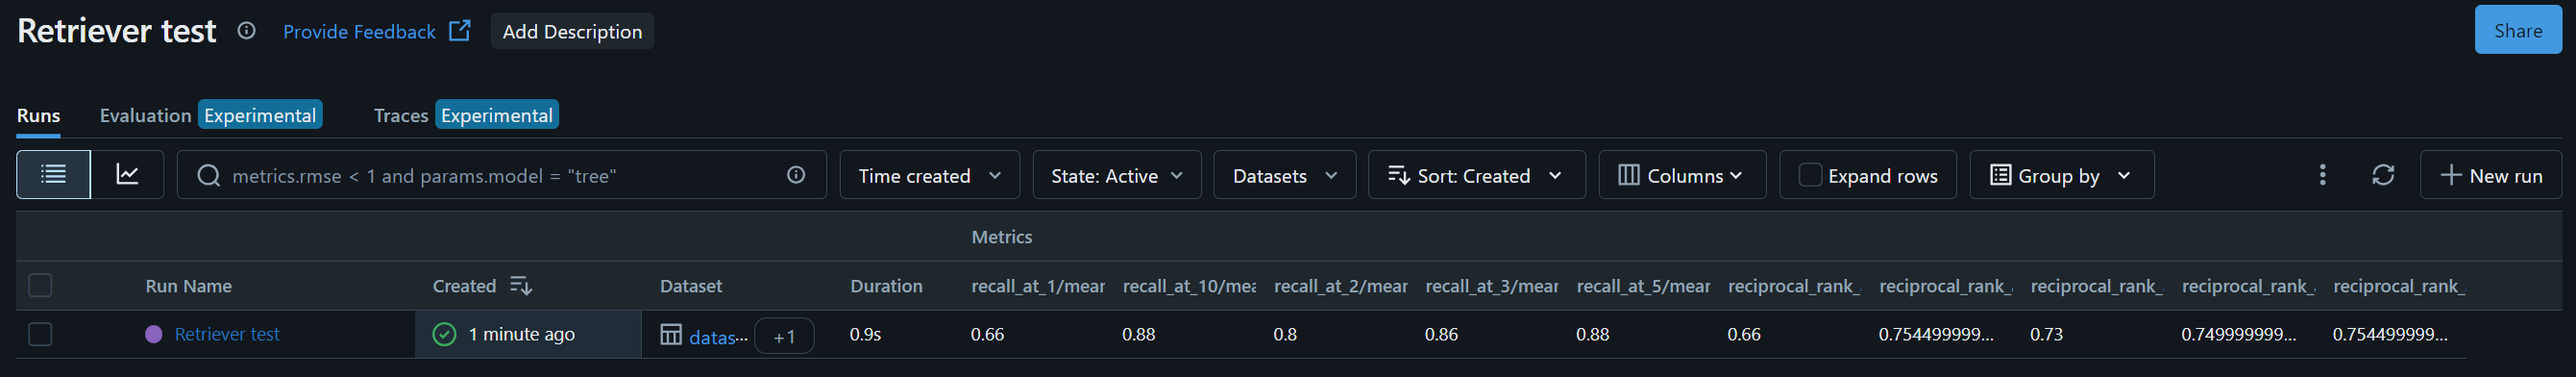
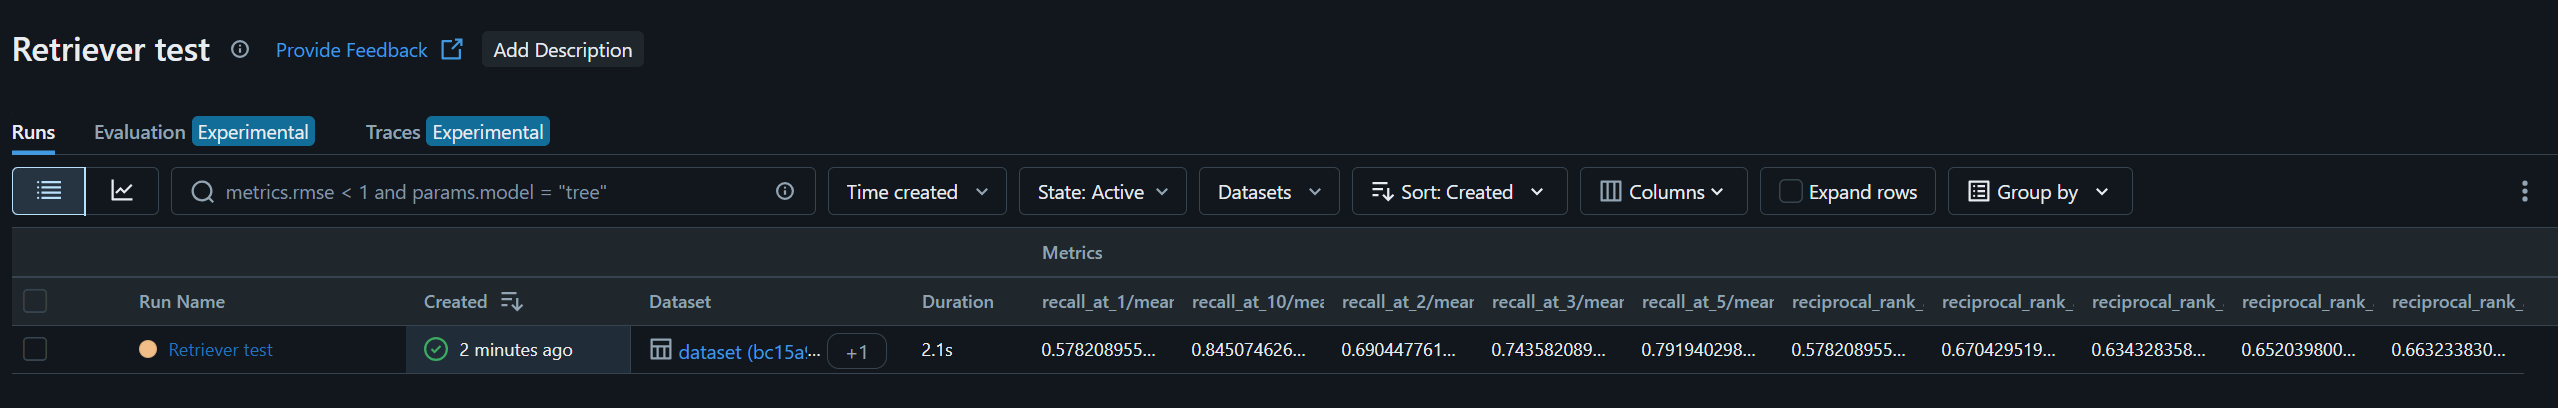

---

## Тестирование качества ответов RAG  

Для оценивания качества были сгенерированы 3350 вопросов (по 10 на каждый документ), из них отобраны 100 наиболее похожих на вопросы из реальной жизни.  
Для каждого вопроса был сгенерирован ответ и провалидирован вручную.  

Методика, описываемая далее, позволяет протестировать, хорошо ли отвечает наш RAG на эти вопросы.  
Это полезно, когда мы хотим определить, все ли хорошо с ответами после внесенных в чейн изменений.  

Получим текущие ответы на эталонные вопросы.    
(Опционально, датасет уже содержит примеры "текущих" ответов нашего RAG'a)

In [13]:
chain = get_rag_chain("MistralAI")


def generate_answer(query: str) -> str:
    ans = chain.invoke(query)
    time.sleep(1.5)
    return ans

In [9]:
tqdm.pandas(desc="Getting current questions")
df["answer_example"] = df["question"].progress_apply(generate_answer)

Посчитаем метрики нашего RAG - bleu/rougeL, токсичность ответов.

In [15]:
mlflow.set_experiment(experiment_name="RAG Chain Test")

with mlflow.start_run(run_name="RAG Evaluation"):
    results = mlflow.evaluate(
        data=df[["question", "answer_example", "target_answer"]],
        targets="target_answer",
        predictions="answer_example",
        model_type="question-answering",
        evaluators="default",
        extra_metrics=[mlflow.metrics.bleu(), mlflow.metrics.rougeL()],
    )
    mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(df))

2025/01/20 17:55:54 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
c:\Users\sixxio\miniconda3\envs\lc\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


🏃 View run RAG Evaluation at: http://192.168.3.3:5000/#/experiments/3/runs/349d43b6d6ee4baeb5201db5e992f749
🧪 View experiment at: http://192.168.3.3:5000/#/experiments/3


В результате получим залогированный в mlflow запуск, в котором можно посмотреть такие метрики, как токсичность, bleu/rougeL.  
Также автоматически посчитается читаемость ответа, но там используются метрики, разработанные для текстов на английском языке, так что для нас они не особо релевантны.

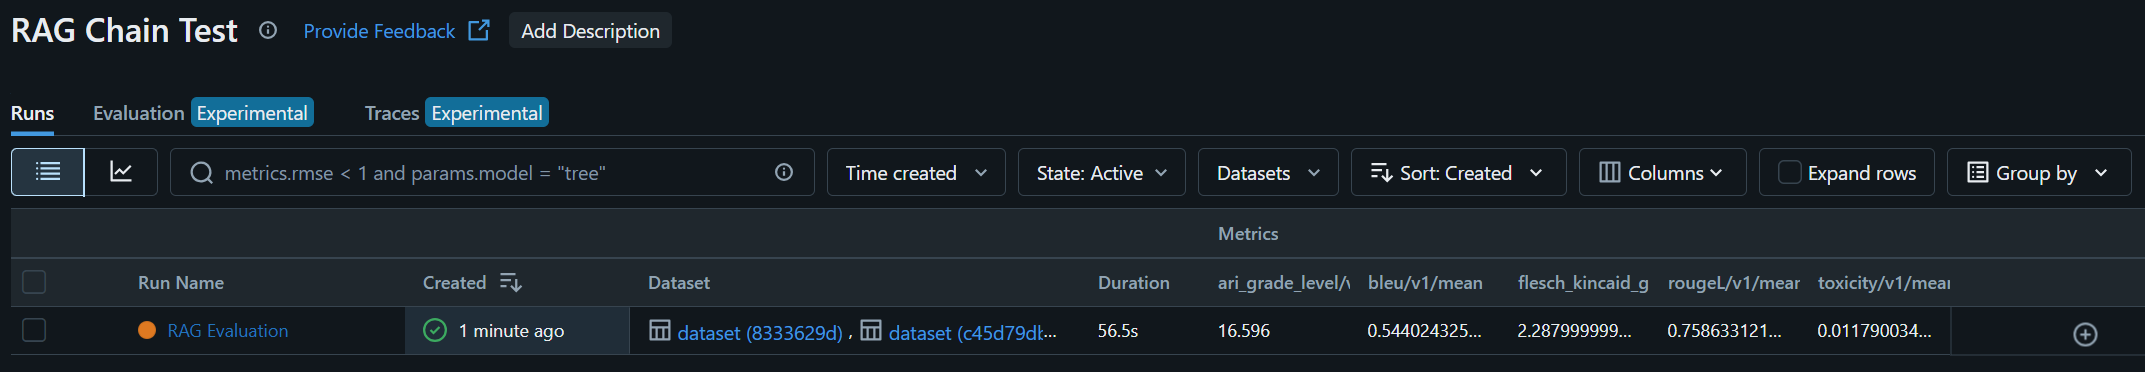

---

## Приложение

### Генерация синтетических вопросов

Читаем все файлы, для каждого генерируем 10 вопросов с помощью модели Mistral Nemo 12b

In [129]:
data_folder = "data/test_vault"

files = os.listdir(data_folder)

text_dicts = []

for file in files:
    with open(f"{data_folder}/{file}", "r") as content:
        text = content.read()
        if len(text) > 8:
            text_dicts += [{"filename": file, "text": text}]

print(f"Valid files total: {len(text_dicts)}")

Valid files total: 335


In [9]:
client = Mistral(api_key="EPQd9IXHTe6bCZoa4w5mzTzTxKfnGBut")

model = "open-mistral-nemo"

system = """я разрабатываю систему для ответа на вопросы, мне нужно протестировать, правильный ли текст используется для получения ответа
сгенерируй 10 вопросов по тексту ниже на русском языке и верни их в формате json {"questions":[".."]}"""


def generate_q(text: str) -> dict:
    chat_completion = client.chat.complete(
        messages=[{"role": "system", "content": system}, {"role": "user", "content": text}],
        model=model,
        response_format={"type": "json_object"},
    )

    return json.loads(chat_completion.choices[0].message.content)

In [ ]:
for text_dict in tqdm(text_dicts, desc="Question generation"):
    text_dict.update({"questions": generate_q(text_dict["text"])})
    time.sleep(1.5)

In [104]:
text_question_dicts = []

for text in text_dicts:
    text_question_dicts += [
        {
            "filename": text["filename"],
            "text": text["text"],
            "question": text["questions"]["questions"][j],
        }
        for j in range(10)
    ]

print(f"Questions total: {len(text_question_dicts)}")

Questions total: 3350
